# In this notebook a Tracks Class from filters.py is used to calculate different features of tracks and assist in applying filters accordingly 

In [1]:
import pandas as pd 
import numpy as np 
import sys
sys.path.append('../src/')
from filters import Track, create_tracks_from_dataframe, drop_short_tracks
from filters import drop_early_peak_tracks, drop_last_frame_peak_tracks, drop_tracks_below_intensity
from filters import plot_z_sum, allocate_membrane_regions, plot_z_sum_bd
import napari
import zarr
import dask.array as da

In [2]:
track_df = pd.read_pickle("/Users/apple/Desktop/Akamatsu_Lab/Data/full_movie_output_zarr/track_df_cleaned_final_full.pkl")

z2 = zarr.open('/Users/apple/Desktop/Akamatsu_Lab/Data/Zarr_file_new/all_channels_data', mode='r')
z2.shape

(130, 3, 116, 2052, 340)

In [3]:
track_df.head()

,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,...,c2_peak_mean,c2_voxel_sum,c2_voxel_sum_adjusted,c1_amp,c1_peak,c1_peak_x,c1_peak_y,c1_peak_z,c1_voxel_sum,c1_voxel_sum_adjusted
0,0,0,175.000000,19.0,1813.0,3.0,2.0,1.0,2.0,0,...,119.653333,15009,-145.938776,134.720000,156,19,1813,5,13216,-118.153846
1,0,1,188.000000,24.0,1804.0,4.0,2.0,2.0,3.0,0,...,115.931429,14668,-284.489796,139.565714,167,24,1806,5,15629,-136.909091
2,0,2,182.305173,49.0,569.0,4.0,2.0,1.0,2.0,0,...,108.906667,13769,-69.367347,118.173333,138,50,568,4,13305,199.090909
3,0,3,176.000000,134.0,739.0,4.0,2.0,2.0,3.0,0,...,119.777143,15401,212.102041,164.662857,217,132,738,7,18473,-691.727273
4,0,4,178.000000,39.0,1124.0,4.0,3.0,2.0,3.0,0,...,117.432653,14998,139.551020,150.069388,199,40,1124,7,16814,-481.090909


In [4]:
track_df.shape

(515935, 34)

In [5]:
tracks = create_tracks_from_dataframe(df = track_df, intensities_col_name = ['amplitude', 'c2_peak', 'c1_peak'], 
track_id_col_name = 'track_id', frame_col_name = 'frame', coords = ['mu_x', 'mu_y', 'mu_z'])

In [6]:
# Create DataFrame from Track instances
tracks_data = {
    'track_id': [track.track_id.values[0] for track in tracks],
    'track_length': [track.track_length for track in tracks],
    'track_start': [track.track_start for track in tracks],
    'track_end': [track.track_end for track in tracks],
    'c3_peak': [track.peak_intensities[0] for track in tracks],
    'c2_peak': [track.peak_intensities[1] for track in tracks],
    'c1_peak': [track.peak_intensities[2] for track in tracks],
    'c3_peak_frame': [track.peak_intensity_frames[0] for track in tracks],
    'c2_peak_frame': [track.peak_intensity_frames[1] for track in tracks],
    'c1_peak_frame': [track.peak_intensity_frames[2] for track in tracks],
    'mean_displacement': [track.mean_displacement_track for track in tracks],
    'mean_z': [track.mean_z_value for track in tracks],
    'mean_z_displacement': [track.mean_z_displacement for track in tracks]
}

tracks_df = pd.DataFrame(tracks_data)

In [7]:
tracks_df.head()

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement
0,0,2,0,1,179.859482,141.0,168.0,1,1,1,5.099020,3.5,1.0
1,1,2,0,1,200.000000,142.0,167.0,1,0,0,3.316625,3.5,1.0
2,2,1,0,0,182.305173,123.0,138.0,0,0,0,NaN,4.0,NaN
3,3,1,0,0,176.000000,148.0,217.0,0,0,0,NaN,4.0,NaN
4,4,1,0,0,178.000000,137.0,199.0,0,0,0,NaN,4.0,NaN


In [8]:
tracks_df[tracks_df['track_id']==541]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement
541,541,2,0,1,188.024784,142.0,208.0,0,0,0,4.242641,13.0,4.0


In [9]:
tracks_df.shape

(198329, 13)

# DROPPING SHORT TRACKS 

In [10]:
#dropping tracks of length 3 and below
length_filtered_tracks_df = drop_short_tracks(df = tracks_df, threshold = 3)

In [11]:
length_filtered_tracks_df.shape

(52376, 13)

## Determining Valid Channel 3 tracks 

### Dropping tracks with Clathrin (Channel 3 peak in the last frame)

In [12]:
valid_c3_tracks = drop_last_frame_peak_tracks(df = length_filtered_tracks_df, intensity_col = 'c3_peak_frame')

In [13]:
valid_c3_tracks.shape

(42404, 13)

### Dropping tracks with Clathrin (Channel 3) which have their peaks in the first three frames 

In [14]:
valid_c3_tracks = drop_early_peak_tracks(df = valid_c3_tracks, intensity_peak_frame = 'c3_peak_frame', 
                                      cutoff = 3)

In [15]:
valid_c3_tracks.shape

(8368, 13)

**valid_c3_tracks will serve as baseline clathrin positive and valid tracks**

# Filtering for Channel 2 (Dynamin)

## Filter 1 
### Identifying Dynamin Positive Tracks 

In [16]:
dnm2_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = 150, 
                                          intensity_peak_frame = 'c2_peak')

In [17]:
dnm2_positive_tracks.shape

(7162, 13)

## Filter 2
### Filter tracks based on channel 2 peak if occurs within 3 frames of starting of a track 

In [18]:
dnm2_positive_tracks = drop_early_peak_tracks(df = dnm2_positive_tracks, intensity_peak_frame = 'c2_peak_frame', 
                                      cutoff = 3)

In [19]:
dnm2_positive_tracks.shape

(4279, 13)

## Filter 3
### Filter tracks based on channel 2 peaks occuring in the last frame 

In [20]:
dnm2_positive_tracks = drop_last_frame_peak_tracks(df = dnm2_positive_tracks, intensity_col = 'c2_peak_frame')

In [21]:
dnm2_positive_tracks.shape

(3602, 13)

**dnm2_positive_tracks will serve as the baseline for dynamin positive tracks**

# Identifying Channel 1 (Actin) positive tracks 

## Filter 1 
### Identifying Actin Positive Tracks 

In [22]:
actin_positive_tracks = drop_tracks_below_intensity(df = valid_c3_tracks, threshold = 240, 
                                          intensity_peak_frame = 'c1_peak' )

In [23]:
actin_positive_tracks.shape

(6017, 13)

## Filter 2 
### Filter tracks based on channel 1 peaks if occurs within the first 3 frames 

In [24]:
actin_positive_tracks = drop_early_peak_tracks(df = actin_positive_tracks, intensity_peak_frame = 'c1_peak_frame', 
                                      cutoff = 3)

In [25]:
actin_positive_tracks.shape

(3757, 13)

## Filter 3
### Filter tracks based on channel 1 peaks occuring in the last frame 

In [26]:
actin_positive_tracks = drop_last_frame_peak_tracks(df = actin_positive_tracks, intensity_col = 'c1_peak_frame')

In [27]:
actin_positive_tracks.shape

(3108, 13)

# Combining actin and dynamin positive tracks with valid clathrin positive tracks 

In [28]:
final_tracks = valid_c3_tracks.copy(deep = True)

In [29]:
final_tracks['dnm2_positive'] = False 

In [30]:
final_tracks['actin_positive'] = False 

In [31]:
final_tracks.head()

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
40,40,18,0,17,263.000000,155.0,270.0,11,13,5,1.630886,11.444444,1.058824,False,False
82,82,26,0,25,231.000000,161.0,209.0,24,8,8,2.000099,11.961538,1.320000,False,False
87,87,10,0,9,209.714192,152.0,266.0,4,9,1,1.541002,12.000000,1.000000,False,False
138,138,17,0,16,279.099930,159.0,243.0,15,7,4,2.889447,13.764706,1.937500,False,False
142,142,13,0,12,205.000000,151.0,221.0,10,12,4,1.392898,11.153846,0.833333,False,False


***Setting actin positive tracks to True***

In [32]:
# Get the track IDs from actin_positive_tracks
actin_positive_track_ids = actin_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(actin_positive_track_ids), 'actin_positive'] = True

In [33]:
final_tracks[final_tracks['actin_positive'] == True]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
40,40,18,0,17,263.000000,155.0,270.0,11,13,5,1.630886,11.444444,1.058824,False,True
138,138,17,0,16,279.099930,159.0,243.0,15,7,4,2.889447,13.764706,1.937500,False,True
198,198,12,0,11,252.333333,160.0,274.0,9,6,7,1.225935,13.333333,0.818182,False,True
215,215,16,0,15,231.000000,150.0,256.0,6,12,12,1.746456,11.875000,1.333333,False,True
217,217,25,0,24,248.000000,222.0,346.0,18,19,19,1.409304,15.320000,0.791667,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189449,189449,8,122,129,235.333333,215.0,626.0,126,129,126,2.458009,107.500000,1.714286,False,True
189806,189806,7,123,129,199.000000,152.0,288.0,128,123,128,2.799222,26.857143,1.666667,False,True
190019,190019,7,123,129,226.485961,185.0,280.0,128,129,127,2.211709,46.000000,1.666667,False,True
190260,190260,7,123,129,206.273117,155.0,268.0,128,128,128,2.375435,73.571429,1.333333,False,True


In [34]:
actin_rows_count = final_tracks[final_tracks['actin_positive'] == True].shape[0]
print(f'number of actin positive tracks are: {actin_rows_count}')

number of actin positive tracks are: 3108


***Setting dynamin positive tracks to True***

In [35]:
# Get the track IDs from actin_positive_tracks
dnm2_positive_track_ids = dnm2_positive_tracks['track_id']

# Set 'actin_positive' to True for rows where 'track_id' is in positive_track_ids
final_tracks.loc[final_tracks['track_id'].isin(dnm2_positive_track_ids), 'dnm2_positive'] = True

In [36]:
final_tracks[final_tracks['dnm2_positive'] == True]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
40,40,18,0,17,263.000000,155.0,270.0,11,13,5,1.630886,11.444444,1.058824,True,True
82,82,26,0,25,231.000000,161.0,209.0,24,8,8,2.000099,11.961538,1.320000,True,False
138,138,17,0,16,279.099930,159.0,243.0,15,7,4,2.889447,13.764706,1.937500,True,True
198,198,12,0,11,252.333333,160.0,274.0,9,6,7,1.225935,13.333333,0.818182,True,True
201,201,11,0,10,270.269789,168.0,230.0,6,5,9,1.433584,11.545455,0.700000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189978,189978,7,123,129,198.000000,157.0,198.0,128,128,127,2.421164,45.428571,1.333333,True,False
190123,190123,7,123,129,233.000000,166.0,254.0,127,128,126,2.584034,57.714286,1.333333,True,False
190246,190246,7,123,129,273.861717,157.0,311.0,128,127,124,3.505603,74.571429,2.666667,True,False
190260,190260,7,123,129,206.273117,155.0,268.0,128,128,128,2.375435,73.571429,1.333333,True,True


In [37]:
dnm2_rows_count = final_tracks[final_tracks['dnm2_positive'] == True].shape[0]
print(f'number of dynamin positive tracks are: {dnm2_rows_count}')

number of dynamin positive tracks are: 3602


In [38]:
final_tracks[(final_tracks['dnm2_positive'] == True) & (final_tracks['actin_positive'] == True)]

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive
40,40,18,0,17,263.000000,155.0,270.0,11,13,5,1.630886,11.444444,1.058824,True,True
138,138,17,0,16,279.099930,159.0,243.0,15,7,4,2.889447,13.764706,1.937500,True,True
198,198,12,0,11,252.333333,160.0,274.0,9,6,7,1.225935,13.333333,0.818182,True,True
217,217,25,0,24,248.000000,222.0,346.0,18,19,19,1.409304,15.320000,0.791667,True,True
247,247,18,0,17,275.807613,183.0,244.0,9,5,5,1.149987,12.277778,0.529412,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187306,187306,9,121,129,236.121554,160.0,257.0,127,128,128,1.833732,32.555556,0.375000,True,True
188409,188409,8,122,129,240.333333,160.0,309.0,126,127,126,1.746682,21.500000,1.428571,True,True
188661,188661,7,122,128,223.013520,156.0,270.0,127,126,126,1.814654,40.428571,0.666667,True,True
189448,189448,8,122,129,226.000000,161.0,276.0,126,127,126,2.819957,106.750000,2.000000,True,True


In [39]:
actin_dnm2_rows_count = final_tracks[(final_tracks['dnm2_positive'] == True) & 
                                     (final_tracks['actin_positive'] == True)].shape[0]
print(f'number of dynamin and actin positive tracks are: {actin_dnm2_rows_count}')

number of dynamin and actin positive tracks are: 1758


# Allocating Apical/Basal/Lateral boundaries to tracks
Using channel 1 (actin) for this purpose 

(116, 2052, 340)
frame is 0
(116, 2052, 340)
frame is 32
(116, 2052, 340)
frame is 65
(116, 2052, 340)
frame is 97
(116, 2052, 340)
frame is 129


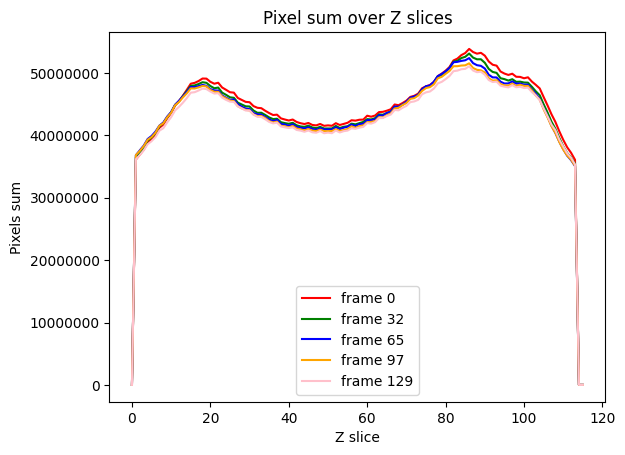

In [40]:
#channel is hard coded in the function right now. Need to allow it to be passed as a parameter by the user 
plot_z_sum_bd(z2)

Based on the above results the following boundaries can be determined
1. Basal (0-18)
2. Lateral(19-84)
3. Apical(85-116)

In [41]:
allocate_membrane_regions(df = final_tracks, basal_range = [0,19] , lateral_range = [19,85], apical_range = [85,116])

,track_id,track_length,track_start,track_end,c3_peak,c2_peak,c1_peak,c3_peak_frame,c2_peak_frame,c1_peak_frame,mean_displacement,mean_z,mean_z_displacement,dnm2_positive,actin_positive,membrane_region
40,40,18,0,17,263.000000,155.0,270.0,11,13,5,1.630886,11.444444,1.058824,True,True,Basal
82,82,26,0,25,231.000000,161.0,209.0,24,8,8,2.000099,11.961538,1.320000,True,False,Basal
87,87,10,0,9,209.714192,152.0,266.0,4,9,1,1.541002,12.000000,1.000000,False,False,Basal
138,138,17,0,16,279.099930,159.0,243.0,15,7,4,2.889447,13.764706,1.937500,True,True,Basal
142,142,13,0,12,205.000000,151.0,221.0,10,12,4,1.392898,11.153846,0.833333,False,False,Basal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191481,191481,6,124,129,277.558445,149.0,326.0,128,129,124,1.769287,62.333333,1.600000,False,False,Lateral
191500,191500,6,124,129,221.966008,176.0,262.0,128,127,125,1.559309,68.166667,0.800000,False,False,Lateral
191535,191535,6,124,129,209.000000,133.0,256.0,128,129,129,1.744551,71.333333,1.000000,False,False,Lateral
191644,191644,6,124,129,314.492478,184.0,763.0,128,126,129,1.229253,79.166667,0.200000,False,False,Lateral


# Visualising tracks in Napari 

In [ ]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
channel_3 = dask_array[:,:,:,4:2050,:]

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(channel_3, channel_axis = 1, name = ['actin', 'dynamin', 'clathrin'])
#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

In [ ]:
viewer.add_tracks(track_df[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'all tracks')

In [ ]:
#Displaying Dynamin Positive tracks only (Tracks where actin is not present)
dnm2_positive_tracks_df = final_tracks[(final_tracks['dnm2_positive'] == True) & (final_tracks['actin_positive'] == False)]
dnm2_tracks_list = dnm2_positive_tracks_df['track_id'].values
track_1 = track_df[track_df['track_id'].isin(dnm2_tracks_list)]
viewer.add_tracks(track_1[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'dynamin+ tracks')

In [ ]:
#Displaying Actin Positive tracks only (Tracks where Dynamin is not present)
actin_positive_tracks_df = final_tracks[(final_tracks['dnm2_positive'] == False) & (final_tracks['actin_positive'] == True)]
actin_tracks_list = actin_positive_tracks_df['track_id'].values
track_2 = track_df[track_df['track_id'].isin(actin_tracks_list)]
viewer.add_tracks(track_2[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'actin+ tracks')

In [ ]:
#Displaying all 3 channels positive tracks 
all_positive_tracks_df = final_tracks[(final_tracks['dnm2_positive'] == True) & (final_tracks['actin_positive'] == True)]
all_positive_tracks_list = all_positive_tracks_df['track_id'].values
track_3 = track_df[track_df['track_id'].isin(all_positive_tracks_list)]
viewer.add_tracks(track_3[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'all+ tracks')

In [ ]:
#Displaying basal tracks 
basal_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Basal']
basal_tracks_list = basal_tracks_df['track_id'].values
track_4 = track_df[track_df['track_id'].isin(basal_tracks_list)]
viewer.add_tracks(track_4[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'basal tracks')

In [ ]:
#Displaying lateral tracks 
lateral_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Lateral']
lateral_tracks_list = lateral_tracks_df['track_id'].values
track_5 = track_df[track_df['track_id'].isin(lateral_tracks_list)]
viewer.add_tracks(track_5[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'Lateral tracks')

In [ ]:
#Displaying apical tracks 
apical_tracks_df = final_tracks[final_tracks['membrane_region'] == 'Apical']
apical_tracks_list = apical_tracks_df['track_id'].values
track_6 = track_df[track_df['track_id'].isin(apical_tracks_list)]
viewer.add_tracks(track_6[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = 'Apical tracks')

In [42]:
final_tracks.to_pickle("/Users/apple/Desktop/Akamatsu_Lab/Data/full_movie_output_zarr/filtered_tracks_final.pkl")